# Applying Solution to Simplified, Small Scale Streets Data


This notebook implements the crossover algorithm between two routes. It also stores a route as only a list of non-deadheaded edges.


In [43]:
import networkx as nx
import geopandas as gpd
import momepy
import pandas as pd
import copy
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import osmnx as ox
import shapely

In [44]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

In [45]:
G = nx.DiGraph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())
    G.add_edge(edges.iloc[1],edges.iloc[0],**edges.iloc[2:].to_dict())


for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})

In [46]:
def print_graph_attributes(G, nodes=True, edges=True):
    if nodes:
        for node in G.nodes(data=True):
            print(node)
    if edges:
        for edge in G.edges(data=True, keys=True):
            print(edge)

In [47]:
DEPOT = 0

## Add Graph Attributes


Add node information

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

Also, calculate the weighted degree of each node, defined as
$$\text{WeightedDeg(v)} = \sum_{e \in E_v} e(\text{passes})\cdot e(\text{priority})$$

Also, update the total amount of salting required for the road given the number of passes

In [48]:
def config_graph_attributes(G):
    for node in G.nodes:
        weight_deg = 0
        for edge in G.edges([node], data=True):
            weight_deg += edge[2]['passes_rem']*edge[2]['priority']
        G.nodes[node]['weighted_degree'] = weight_deg
    # add a new attribute to each edge, called "deadheading_passes" and initially set to 0
    for edge in G.edges(data=True):
        edge[2]['deadheading_passes'] = 0


config_graph_attributes(G)
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}


In [49]:
G_strong_multi = nx.MultiDiGraph(G)

for edge in G.edges(data=True):
    attrbs = edge[2]
    zip(attrbs.keys(), attrbs.values())
    for i in range(int(attrbs['passes_rem']-1)):
        G_strong_multi.add_edge(edge[0], edge[1])
        nx.set_edge_attributes(G_strong_multi, {(edge[0], edge[1],i+1):attrbs})

nx.set_edge_attributes(G_strong_multi, False, "serviced")

## Plotting Multigraphs

In [50]:
def draw_labeled_multigraph(G, pos, attr_name, ax=None, color='blue'):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    node_lables = dict([(node, node) for node in G.nodes()]) # label the nodes

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightgreen", node_size = 1000)
    nx.draw_networkx_labels(G, pos, font_size=50, ax=ax, labels=node_lables)
    nx.draw_networkx_edges(
        G, pos, width = 3, edge_color="grey", arrows=True, connectionstyle=connectionstyle, ax=ax, arrowsize=50
    )
    if attr_name is not None:
        labels = {
            tuple(edge): f"{attrs[attr_name]}"
            for *edge, attrs in G.edges(keys=True, data=True)
        }
        nx.draw_networkx_edge_labels(
            G,
            pos,
            labels,
            connectionstyle=connectionstyle,
            label_pos=0.5,
            font_color=color,
            font_size=25,
            bbox={"alpha": 0},
            ax=ax,
        )

def add_order_attribute(G, routes):
    G_graph = G.copy()
    count = 0
    for route in routes:
        for step in route:
            if G_graph[step.node1][step.node2][step.id].get('order') is None:
                G_graph[step.node1][step.node2][step.id]['order'] = str(count)
            else:
                G_graph[step.node1][step.node2][step.id]['order'] += ", " + str(count)
            count += 1
    for edge in G_graph.edges(data=True):
        if edge[2].get('order') is None:
            edge[2]['order'] = "UNSERVICED"

    return G_graph

def add_order_attribute_from_edges(G, routes):
    G_graph = G.copy()
    count = 0
    for route in routes:
        for edge in route:
            if G_graph[edge[0]][edge[1]][edge[2]].get('order') is None:
                G_graph[edge[0]][edge[1]][edge[2]]['order'] = str(count)
            else:
                G_graph[edge[0]][edge[1]][edge[2]]['order'] += ", " + str(count)
            count += 1
    for edge in G_graph.edges(data=True):
        if edge[2].get('order') is None:
            edge[2]['order'] = "UNSERVICED"

    return G_graph



# Step 3: Create a Dual Representation of the Graph

This is crucial to include turn directions as weights in shortest-paths.

In [51]:
from math import atan2
from math import pi
def angle(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

def turn_direction(angle):
    '''
    Returns the direction of a turn given an angle
    '''
    if angle < 15 and angle > -15:
        return "straight"
    elif angle >= -90 and angle <= -15:
        return "right"
    elif angle <= 90 and angle >= 15:
        return "left"
    elif angle <= 135 and angle > 90:
        return "sharp left"
    elif angle >= -135 and angle < -90:
        return "sharp right"
    else:
        return "u-turn"

def identify_cost(G_primal, G_dual, edge1_dual, edge2_dual):
    '''
    Identifies the cost of traversing from edge1 to edge2
    nodes of the format: 
    edge1_dual = (node1, node2, id)
    '''
    # cost is the cost of traversing the first edge (otherwise we doublecount costs in shortest path algorithm)
    cost = G_primal[edge1_dual[0]][edge1_dual[1]][edge1_dual[2]]['travel_time']
    # add the turn penalty cost
    turn_penalty = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    first_node = edge1_dual[0]
    second_node = edge1_dual[1]
    third_node = edge2_dual[1]
        

    v_x = G_primal.nodes[second_node]['x']-G_primal.nodes[first_node]['x']
    v_y = G_primal.nodes[second_node]['y']-G_primal.nodes[first_node]['y']

    w_x = G_primal.nodes[third_node]['x']-G_primal.nodes[second_node]['x']
    w_y = G_primal.nodes[third_node]['y']-G_primal.nodes[second_node]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    cost += turn_penalty[turn_direction(theta)]

    return cost

In [52]:
def create_dual(G: nx.MultiDiGraph, depotSource: bool=False, sourceNodes: bool=True):
    L = nx.MultiDiGraph()

    # Create a graph specific edge function.
    for from_node in G.edges(keys=True, data=True):
        # from_node is: (u,v,key, attrb)
        L.add_node(from_node[:3])
        for to_node in G.edges(from_node[1], keys=True, data=True):
            L.add_edge(from_node[:3], to_node[:3])
            L.edges[from_node[:3], to_node[:3], 0]['weight'] = identify_cost(G, L, from_node[:3], to_node[:3])
    
    if sourceNodes:
        # add source and target nodes
        for node in G:
            L.add_node(str(node) + "_source", weight=0)
        # add edges connecting source and targets to valid gateways
        for node in L.nodes():
            # skip the source nodes which are strings. The other nodes are tuples
            if (type(node) == str):
                continue
                
            # for a digraph, not a multigraph:
            # source -> first node
            # second node -> source
            L.add_edge(str(node[0]) + "_source", node, weight=0)
            # L.add_edge(str(node[1]) + "_source", node, weight=0) only for undirected

            # L.add_edge(node, str(node[0]) + "_source", weight=0) only for undirected
            L.add_edge(node, str(node[1]) + "_source", weight=0)

    if depotSource:
        L.add_node(DEPOT, weight=0)
        for edge in G.edges(DEPOT, keys=True):
            L.add_edge(DEPOT, edge, weight=0)
        for edge in G.in_edges(DEPOT, keys=True):
            L.add_edge(edge, DEPOT, weight=0)
    return L



In [53]:
G_dual = create_dual(G_strong_multi, True, False)
print(G_dual)

MultiDiGraph with 15 nodes and 50 edges


# Step 4: Precompute Shortest Paths

In [54]:
edge_index_dict = {edge:index for index, edge in enumerate(G_dual.nodes)}

In [55]:
predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G_dual, weight='weight')
dists_array = nx.floyd_warshall_numpy(G_dual, weight='weight')

# print(distances[(1, 2, 0)][(2,3,0)])

# print(dists_array[edge_index_dict[(1,2,0)], edge_index_dict[(2,3,0)]])

# dists_array

In [56]:
def get_dist(edge1, edge2):
    '''
    Returns the shortest distance between two edges of the graph
    '''
    node1 = edge_index_dict[edge1]
    node2 = edge_index_dict[edge2]
    return dists_array[node1][node2]

# Step 5: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
| S_i | Amount of salt required to service road i |
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

## Defining a Class for the Routes

We want to keep track of certain attributes of each traversed edge for backtracking purposes. Let's create a class to manage all the variables

In [57]:
class RouteStep:
    """
    Represents a step in a route.

    Attributes:
        node1 (str): The starting node of the step.
        node2 (str): The ending node of the step.
        id (int): The id of the step (identifier for parallel edges)
        wasDeadheaded (bool): Indicates whether the step was a deadhead (empty) move.
        hadOptions (bool): Indicates whether the step had multiple options for routing. Could have gone a different direction
        saltval (int): Indicates the amount of salt the vehicle had before traversing the arc. Useful for checking validity of solution
    """
    def __init__(self, node1="", node2="", id=0, wasDeadheaded=False, hadOptions=False, saltval = 0):
        self.node1 = node1
        self.node2 = node2
        self.id = id
        self.wasDeadheaded = wasDeadheaded
        self.hadOptions = hadOptions
        self.saltval = saltval

    def __str__(self):
        return f"{self.node1} --> {self.node2}. ({self.id}) Deadhead: {self.wasDeadheaded}. Had options: {self.hadOptions}. Salt value: {self.saltval}"

    def __repr__(self):
        return str(self)


## Identifying Turn Directions at an Intersection - **No Modifications Required**

Methodology: Use coordinate system. Identify the three coordinates of the triangle (can be degenerate) that every turn makes. Potential for linear algebra: dot product of the two vectors, or change of basis?

Example: going from (2,1) to (0,1) to (-1,-1)

v = [-2, 0]
w = [-1, -2]

Create a function that computes the cost of traversing an arc

In [58]:
from math import atan2
from math import pi
def angle_vector(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

In [59]:
def cost(G, prev, curr, nxt, k):
    '''
    Returns the cost of traversing an edge between two nodes. Based on distance and turn direction
    '''
    cost = G[curr][nxt][k]['travel_time']

    # without previous node, we can't factor turn direction
    if prev is None:
        return cost
    
    # with a previous node, we incorporate turning penalites
    turn_cost = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    v_x = G.nodes[curr]['x']-G.nodes[prev]['x']
    v_y = G.nodes[curr]['y']-G.nodes[prev]['y']

    w_x = G.nodes[nxt]['x']-G.nodes[curr]['x']
    w_y = G.nodes[nxt]['y']-G.nodes[curr]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle_vector(v,w)
    cost += turn_cost[turn_direction(theta)]

    return cost

In [60]:
def needs_servicing(G, node1, node2, id):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2][id]['serviced'] == False

### Start finding a route

Check if there are any required arcs remaining departing from the current node

Do we need to flip the arc ever? It's dangerous to do in a directed graph, and I don't think its necessary if all the nodes are being kept track of properly

In [61]:
def visit_arc(G: nx.Graph, curr: str, arc: tuple, route: list, options: bool, curr_salt : float, route_required : list[RouteStep] = [], undirected=False,):
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        curr (str): the current node
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        str: The new node that the arc is on
    '''

    # identify the direction of traversal. fixed by def of digraph
    from_node = arc[0] # if arc[0] == curr else arc[1]
    to_node = arc[1] # if from_node == arc[0] else arc[0]
    id = arc[2]
    # initialize routstep object
    route_step = RouteStep(from_node, to_node, id, hadOptions=options, saltval=curr_salt)

    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[from_node][to_node][id]['salt_per']

    # needs servicing and we can service it. Update weighted and effective degree
    if needs_servicing(G, from_node, to_node, id) and curr_salt >= salt_required:
        G.nodes[from_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']
        if (undirected):
            G.nodes[to_node]['weighted_degree'] -= G[from_node][to_node][id]['priority']

        curr_salt -= salt_required

        G[from_node][to_node][id]['passes_rem'] -= 1 # mark that we traversed this arc
        G[from_node][to_node][id]['serviced'] = True
        route_step.wasDeadheaded = False
        route_required.append((from_node, to_node, id))
        
    else:
        G[from_node][to_node][id]['deadheading_passes'] += 1
        route_step.wasDeadheaded = True

    route.append(route_step)
    return to_node, curr_salt

In [62]:
def process_node(G, prev, curr):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr], data=True, keys=True):
        nxt = edge[1]
        k = edge[2] # identifier for parallel edges
        if edge[3]["serviced"] == False:
            required.append(edge)
            c_min = min(cost(G, prev, curr, nxt, k), c_min)
            c_max = max(cost(G, prev, curr, nxt, k), c_max)
    return required, c_min, c_max

Since G_dual is never a multigraph, shortest paths shouldn't actually require modifying.

In [63]:
def move_between_nodes(G, G_dual, node1, node2, route_up_to_now, route_required, salt, options=False):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 

    '''
    node_path = nx.dijkstra_path(G_dual, str(node1)+"_source", str(node2)+"_source", weight="weight")
    
    # remember, nodes in the dualgraph are edges in the primal graph
    edges = [node for node in node_path if type(node) != str] # ignore source nodes
    curr = node1
    for edge in edges:
        curr, salt = visit_arc(G, curr, edge, route=route_up_to_now, route_required=route_required, options=options, curr_salt=salt)

Quick test of move_between_nodes

In [64]:

def has_edge_within_capacity(G, node, curr_salt):
    if curr_salt == 0:
        return False
    for neighbor_edge in G.edges(node, data=True, keys=True):
        if neighbor_edge[3]['salt_per'] <= curr_salt and neighbor_edge[3]['serviced'] == False:
            return True
    return False

'''
def find_nearest_required(G, G_dual, node):
    
    # Depracated. Finds the path to the nearest node with a required arc to traverse.
    
    dists = dict()
    for target in G.nodes():
        distance = nx.dijkstra_path_length(G_dual, str(node) + "_source", str(target) + "_source", weight="weight")
        dists[target] = distance
    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for target in G.nodes():
        if target == node:
            continue
        if G.nodes[target]['weighted_degree'] > 0 and dists[target] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, target):
                min_dist = dists[target]
                min_dist_node = target
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_dist_node)+"_source", weight="weight")
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes
    
    return edges
    '''
        

'\ndef find_nearest_required(G, G_dual, node):\n    \n    # Depracated. Finds the path to the nearest node with a required arc to traverse.\n    \n    dists = dict()\n    for target in G.nodes():\n        distance = nx.dijkstra_path_length(G_dual, str(node) + "_source", str(target) + "_source", weight="weight")\n        dists[target] = distance\n    # loop through the dists array and find the nearest required arc\n    min_dist = math.inf\n    min_dist_node = None\n    for target in G.nodes():\n        if target == node:\n            continue\n        if G.nodes[target][\'weighted_degree\'] > 0 and dists[target] < min_dist:\n            # check that the node has an edge to service within salt capacity\n            if has_edge_within_capacity(G, target):\n                min_dist = dists[target]\n                min_dist_node = target\n    \n    if min_dist_node is None:\n        return None\n    # reconstruct path\n    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_di

Can I optimize this further to return sorted neighbors? Or would that prohibitively slow the algorithm

In [65]:
from collections import deque
def find_nearest_required(G : nx.Graph, G_dual, source, salt):
    queue = deque()
 
    # Mark the current node as visited and enqueue it
    visited = set()
    queue.append(source)
    parent = dict() # store predecessors to get the nodepath

    # Iterate over the queue
    while queue:
        # Dequeue a vertex from queue
        currentNode = queue.popleft()

        # Get all adjacent vertices of the dequeued vertex currentNode
        # If an adjacent has not been visited, then mark it visited and enqueue it
        for neighbor in G.neighbors(currentNode):
            if neighbor not in visited:
                # new node. Check if it has edge
                visited.add(neighbor)
                queue.append(neighbor)

                if neighbor not in parent:
                    parent[neighbor] = currentNode

                if G.nodes[neighbor]['weighted_degree'] > 0 and has_edge_within_capacity(G, neighbor, salt):
                    # get the node path
                    node_path_reversed = list()
                    currNode = neighbor
                    while currNode != source:
                        node_path_reversed.append(currNode)
                        currNode = parent[currNode]
                    node_path_reversed.append(source)

                    return reversed_nodes_to_edges(G, node_path_reversed)
    return None

def reversed_nodes_to_edges(G, node_path):
    edge_path = list()
    for i in range(len(node_path)-1,0,-1):
        node1 = node_path[i]
        node2 = node_path[i-1]
        # in case multiple options, pick the edge with lowest weight
        minTime = math.inf
        minEdgeKey = None
        for edgeKey, attr in G[node1][node2].items():
            if minEdgeKey == None or attr['travel_time'] < minTime:
                minEdgeKey = edgeKey
                minTime = attr['travel_time']
        edge_path.append((node1, node2, minEdgeKey))

    return edge_path

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random. Alpha=zero is nearest neighbor heuristic

To choose an arc from the RCL, we either randomly choose or weight based on turn direction and degree of the next intersection.

Parameter: Weights is the amount of weight assigned to turning, degree, and priority. Total weight is 

$$(\text{weights[0]}) \cdot \text{turns} + (\text{weights[1]})\cdot \text{degree} + (\text{weights[2]})\cdot \text{priority}$$

Continue running the route construction algorithm until there are no required nodes in the graph left. Run the algorithm on a copy of G so that the original graph is preserved

Need to add checks for weighted_degree = 0

In [66]:
def chooseArc(G, rcl, prev_node, weights):
    """
    Selects an arc from a Restricted Candidate List (RCL) based on various weights.

    Parameters:
    - G: The graph representing the road network.
    - rcl: The Restricted Candidate List (RCL) containing the arcs to choose from.
    - prev_node: The previous node in the path.
    - weights: A list of weights used to calculate the arc selection probabilities. The first weight is for turn direction, the second weight is for the degree of the next node, and the third weight is for the priority of the arc.
    Precondition: sum of weights is 1.

    Returns:
    - The selected arc from the RCL.

    Algorithm:
    1. If the previous node is None or a random number is greater than 0.8, choose an arc randomly from the RCL.
    2. Calculate weights for each arc in the RCL based on turn direction, degree of the next node, and priority.
    3. Normalize the sum of the weights.
    4. Choose an arc based on the weights, where higher weights are more likely to be chosen.

    Note:
    - The angle, turn_direction, and angle functions are assumed to be defined elsewhere.

    """

    # randomize 20% of the time
    if (random.random() > .8):
        return random.choice(rcl)
    
    turn_weights = {"straight": 6, "right": 5, "left": 4, "sharp right": 3, "sharp left": 2, "u-turn": 1}
    weights_turns = np.empty(len(rcl))
    weights_degrees = np.empty(len(rcl))
    weights_priority = np.empty(len(rcl))

    # calculate weights by turn direction, degree of next node, and priority
    i = 0
    for edge in rcl:
        curr_node = edge[0]
        next_node = edge[1]
        k = edge[2]
        # only calculate turn direction if there is a previous node
        if prev_node is not None:
            v_x = G.nodes[curr_node]['x']-G.nodes[prev_node]['x']
            v_y = G.nodes[curr_node]['y']-G.nodes[prev_node]['y']

            w_x = G.nodes[next_node]['x']-G.nodes[curr_node]['x']
            w_y = G.nodes[next_node]['y']-G.nodes[curr_node]['y']

            v = (v_x, v_y)
            w = (w_x, w_y)

            theta = angle_vector(v,w)

            weights_turns[i] = (turn_weights[turn_direction(theta)])
        weights_degrees[i] = G.nodes[next_node]['weighted_degree']
        weights_priority[i] = G[curr_node][next_node][k]['priority']
        i+=1

    # normalize the sum of the weights

    # check for division by zero. need new normalizing
    if np.sum(weights_degrees) != 0:
        weights_degrees = weights_degrees / np.sum(weights_degrees)
    weights_priority = weights_priority / np.sum(weights_priority)

    if prev_node is not None:
        weights_turns = weights_turns / np.sum(weights_turns)
        weights_tot = weights[0]*weights_turns + weights[1]*weights_degrees + weights[2]*weights_priority
    # if there is no previous node, we are at depot, so turn direction doesn't matter.
    else:
        weights_tot = weights[1]*weights_degrees + weights[2]*weights_priority
    
    # normalize the weights again
    weights_tot = weights_tot / np.sum(weights_tot)
    
    # choose an arc based on the weights (higher weights are more likely to be chosen)
    index = int(np.random.choice(np.linspace(0,len(rcl)-1,len(rcl)), p=weights_tot))
    # print("Weights", weights_tot, "prev node is none?", prev_node is None)
    # print("choice: ", rcl[index][0], rcl[index][1])
    # print("RCl was ", [(edge[0], edge[1]) for edge in rcl])
    return rcl[index]


The weighted degree of the to_node can be zero even fi there is an arc that leads to it that needs to be serviced. This is because it's a digraph, which creates a situation previously impossible in the undirected graph.

In [67]:
SALT_CAP = 100
DEPOT = 0 # choose starting depot node
curr_salt=SALT_CAP

In [68]:
def RCA(G, G_dual, curr_node, alpha, arc_selection_weights, route: list[RouteStep], route_required, DEPOT=DEPOT, curr_salt=curr_salt):
    while True:
        prev_node = route[-1].node1 if len(route) > 0 else None
        
        required_arcs, c_min, c_max = process_node(G, prev_node, curr_node)
        rcl = [] # initialize restricted candidate list
        
        for edge in required_arcs:            
            if cost(G, prev_node, edge[0], edge[1], edge[2]) >= c_min and cost(G, prev_node, edge[0], edge[1], edge[2]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]][edge[2]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            multiple_neighbors = len(G.edges(curr_node)) > 1
            chosen_arc = chooseArc(G, rcl, prev_node, arc_selection_weights)
            curr_node, curr_salt = visit_arc(G, curr_node, chosen_arc, options=multiple_neighbors, route=route, route_required=route_required, curr_salt=curr_salt)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, G_dual, curr_node, curr_salt)
            # no more required arcs in the graph that we can service, so we're done.
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, G_dual, curr_node, DEPOT, route, route_required, salt=curr_salt, options=False) # no other options to traverse
                return route, route_required
            
            # otherwise go to the arc to visit
            for edge in path:
                multiple_neighbors = len(G.edges(curr_node)) > 1 # could we take a different path
                curr_node, curr_salt = visit_arc(G, curr_node, edge, options=multiple_neighbors, route=route, route_required=route_required, curr_salt=curr_salt)
                if curr_node == DEPOT:
                    return route, route_required
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == DEPOT:
            return route, route_required

In [69]:
def all_serviced(G):
    for edge in G.edges(data=True):
        if edge[2]['serviced'] == False:
            return False
    return True

Generate routes.

Getting impossible neighbors. problem with the bfs/adding in a proper order

In [70]:
# define initial conditions
SALT_CAP = 10
DEPOT = 0 # choose starting depot node
curr_node = DEPOT # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G_strong_multi.copy()
G_dual = create_dual(G_copy)
curr_salt = SALT_CAP

routes = list()
routes_onlyRequired = list()

partial_route: list[RouteStep] = list()
partial_route_required: list[RouteStep] = list()

number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route, partial_route_required = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route, partial_route_required)
    routes.append(partial_route)
    routes_onlyRequired.append(partial_route_required)
    curr_salt = SALT_CAP
    curr_node = DEPOT
    partial_route = list()
    partial_route_required = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")

print("New route")
for route in routes_onlyRequired:
    for edge in route:
        print(edge)
    print("*****\n")

Number of routes:1
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 99
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 98
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 97
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 96
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 95
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 94
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 93
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 92
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 91
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 90
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 89
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 88
2 --> 0. (0) Deadhead: False. Had options: True. Salt value: 87
*****

New route
(0, 2, 0)
(2, 3, 0)
(3, 4, 0)
(4, 3, 0)
(3, 2, 0)
(2, 1, 0)
(1, 2,

In [71]:
def route_to_nodes(routes):
    nodes = list()
    for route in routes:
        for step in route:
            nodes.append(step.node1)
    nodes.append(routes[-1][-1].node2)
    return nodes

# Visualize

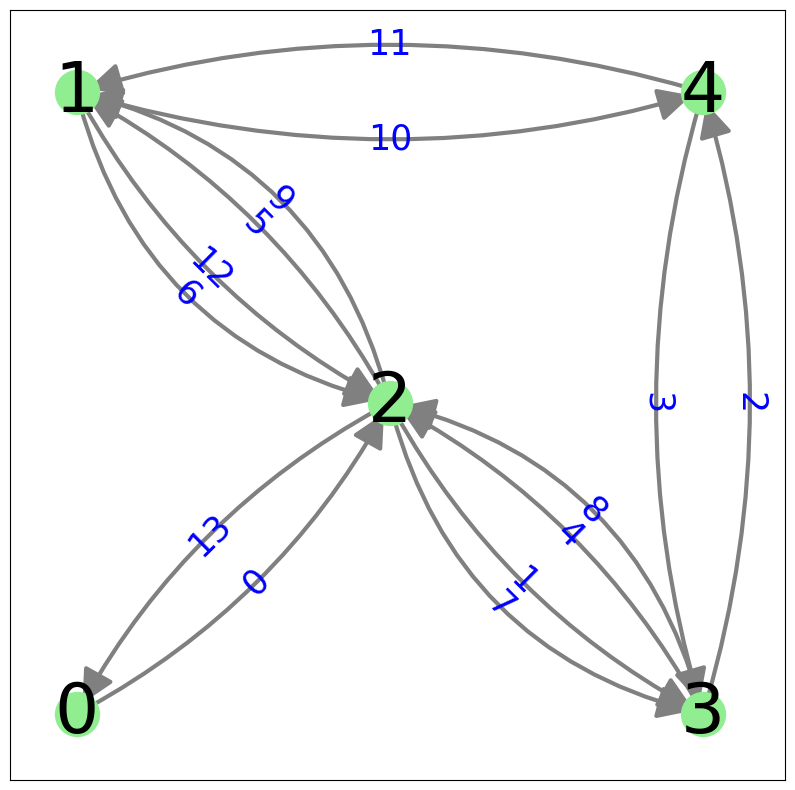

In [72]:
G_Graph = add_order_attribute(G_strong_multi, routes)
draw_labeled_multigraph(G_Graph, node_positions, 'order')


## Evaluating Tour Cost with Prefix Sums

Considerations: Priority. Number of deadheaded routes. Number of returns required to depot (total number of routes). Number of left turns. 

In [73]:
def turn_penalty(G, edge1, edge2):
    penalties = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}
    node1 = edge1[0]
    node2 = edge1[1]
    node3 = edge2[1]

    v_x = G.nodes[node2]['x']-G.nodes[node1]['x']
    v_y = G.nodes[node2]['y']-G.nodes[node1]['y']

    w_x = G.nodes[node3]['x']-G.nodes[node2]['x']
    w_y = G.nodes[node3]['y']-G.nodes[node2]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle_vector(v,w)
    return penalties[turn_direction(theta)]

In [74]:
def routes_cost_updated(G, routes, TURN_PENALTY_FACTOR, NUMROUTES_PENALTY, DEADHEAD_PENALTY):
    cost = 0
    time = 0
    for route in routes:
        for i in range(len(route)):
            routeStep1 = route[i]
            edge = (routeStep1.node1, routeStep1.node2)
            edge_id = routeStep1.id

            # penalize the turn
            if i+1 < len(route):
                next_edge = (route[i+1].node1, route[i+1].node2)
                cost += TURN_PENALTY_FACTOR*turn_penalty(G, edge, next_edge)

            # penalize priority and distance
            edge_data = G[edge[0]][edge[1]][edge_id]
            
            time += edge_data['travel_time'] # edge_data['time']
            priority_cost = edge_data['priority'] * time
            
            cost += edge_data['travel_time']+priority_cost
        # penalize number of returns to depot
        cost += NUMROUTES_PENALTY

    # penalize deadheading
    for edge in G.edges(data=True):
        cost += edge[2]['deadheading_passes']*DEADHEAD_PENALTY
    return cost

routes_cost_updated(G_strong_multi, routes, 10, 1, 1)


663

In [75]:
def subrouteCost(G, route, TURN_PENALTY_FACTOR=10, DEADHEAD_PENALTY=10):
    time = 0
    prefixCosts = []
    for i in range(len(route)):
        cost = 0
        routeStep = route[i]
        edge = (routeStep.node1, routeStep.node2)
        edge_id = routeStep.id

        # penalize the turn
        if i+1 < len(route):
            next_edge = (route[i+1].node1, route[i+1].node2)
            cost += TURN_PENALTY_FACTOR*turn_penalty(G, edge, next_edge)

        # penalize priority and distance
        edge_data = G[edge[0]][edge[1]][edge_id]
        
        time += edge_data['travel_time']
        priority_cost = edge_data['priority'] * time
        
        cost += edge_data['travel_time']+priority_cost
        if routeStep.wasDeadheaded:
            cost += DEADHEAD_PENALTY
        
        # update prefix sum
        if len(prefixCosts) == 0:
            prefixCosts.append(cost)
        else:
            prefixCosts.append(cost + prefixCosts[-1])
    return prefixCosts[-1], prefixCosts


# Step 3: Neighborhood Route Generation

### Algorithm 1: Identifying closed loops

Store the visits in a dictionary. Cycles occur between any two consecutive indices in the dict. 
Cost of cycle from node[i] to node[j] is prefix[j-1] - prefix[i-1] if i > 1 else prefix[j-1]

Time complexity: O(2N)

Going from node representation indices to edge representation indices.

Example:

A->D, D->C, C->B, B->E, E->D

A   , D   , C   , B   , E  , D

D-->D is indices $[1,5]$ in node representation.
The same path is indices $[1,4]$ in arc representation.

Generally, $$[i,j] -> [i, j-1]$$



First, we create a class representing closed loops.

In [76]:
class ClosedLoop:
    """
    Represents a closed loop within a route array.

    Attributes:
        routeID (int): The identifier of the route (which subroute within the larger set of routes it belongs to).
        node (str): The node that the loop is around.
        pos1 (int): The starting position of the loop in the node based array.
        pos2 (int): The ending position of the loop node based array.
        cost (int): The cost of the loop.
    """
    def __init__(self, routeID="", node="", pos1=0, pos2=0, cost=0):
        self.routeID = routeID
        self.node = node
        self.pos1 = pos1
        self.pos2 = pos2
        self.cost = cost

    def __str__(self):
        return f"Route {self.routeID}. Looping around {self.node}. Positions {self.pos1} and {self.pos2}. Cost {self.cost}"

    def __repr__(self):
        return str(self)

    def route_edge_indices(self):
        return (self.pos1, self.pos2-1)


In [77]:
def closed_loops(G, routes):
    closed_loops_all = list()
    for route in routes:
        closed_loops_this = list()
        occurences = dict()

        cTot, cPrefix = subrouteCost(G, route)
        nodeList = route_to_nodes([route])
        for index in range(len(nodeList)):
            node = nodeList[index]

            # Ignore closed loops that contain the depot
            if node == DEPOT:
                continue

            if node not in occurences:
                occurences[node] = [index]
            else:
                occurences[node].append(index)
        
        for node, indices in occurences.items():
            for i in range(len(indices)-1):
                start = indices[i]
                end = indices[i+1]
                cost = cPrefix[end-1] - cPrefix[start-1] if start > 1 else cPrefix[end-1]
                loop = ClosedLoop(routeID=routes.index(route), node=node, pos1=start, pos2=end, cost=cost)
                closed_loops_this.append(loop)
        closed_loops_all.append(closed_loops_this)

    return closed_loops_all

all_closed_loops = closed_loops(G_strong_multi, routes)
for closed_loops_this in all_closed_loops:
    for loop in closed_loops_this:
        print(loop)
    print("*****\n")

Route 0. Looping around 2. Positions 1 and 5. Cost 167
Route 0. Looping around 2. Positions 5 and 7. Cost 99
Route 0. Looping around 2. Positions 7 and 9. Cost 111
Route 0. Looping around 2. Positions 9 and 13. Cost 263
Route 0. Looping around 3. Positions 2 and 4. Cost 88
Route 0. Looping around 3. Positions 4 and 8. Cost 198
Route 0. Looping around 4. Positions 3 and 11. Cost 403
Route 0. Looping around 1. Positions 6 and 10. Cost 202
Route 0. Looping around 1. Positions 10 and 12. Cost 138
*****



### Get the total length and cost of the routes, for normalizing purposes

Identify desirability of each route

## Putting it all together in one function

In [78]:
def getBestClosedLoop(G, routes):
    all_closed_loops = closed_loops(G, routes)

    LENGTH = 0
    for route in routes:
        LENGTH += len(route)
    COST = 0
    for route in routes:
        COST += subrouteCost(G_strong_multi, route)[0]

    def calc_desirability(loop, length, cost):
        return (loop.cost / cost) - (loop.pos2 - loop.pos1) / length
    
    bestDesirability = -math.inf
    bestLoop = None
    for cl in all_closed_loops:
        for loop in cl:
            currDesirability = calc_desirability(loop, LENGTH, COST)

            if currDesirability > bestDesirability:
                bestLoop = loop
                bestDesirability = currDesirability
    return bestLoop


### Remove route with maximum desirability

Problem occurs when you remove two loops from the same route, because then the route_edge_indices shift

Let's just remove one loop at a time. Or re-scan for closed loops each time

In [79]:
def removeLoop(loop : ClosedLoop, routes):
    '''
    Removes a loop from an overarching list of routes
    '''
    route = routes[loop.routeID]
    start, end = loop.route_edge_indices()
    newroute = route[:start] + route[end+1:]
    routes[loop.routeID] = newroute

def removeNLoops(G, routes, n):
    '''
    Returns the new routes with the loops removed, as well as a list containig the removed loops
    '''
    loops_removed = list()

    # make a deep copy of routes
    newRoutes = list()
    for route in routes:
        newRoute = list()
        for step in route:
            newRoute.append(step)
        newRoutes.append(newRoute)

    for i in range(n):
        loop = getBestClosedLoop(G, newRoutes)
        loops_removed.append(loop)
        removeLoop(loop, newRoutes)
    return newRoutes, loops_removed

Visualize deletion

Note that some smaller cycles will be contained within larger subcycles. The big cycle with the depot is also always contained.

Choosing greedily won't always work because we may remove an extremely large section.

Approach:
Weighted desirability of the arc: reward for removing large portion of cost, but penalize the size of the cycle. We don't want to remove massive cycles. We want to remove medium sized cycles.

Two ways to consider insertion:
- Either generate a new way to cover the closed loop using RCL. This will result in a more different route that the other approach
- OR move the deleted cycle to a different portion of the route (swapping the order)

### Repair - regenerate routes on the closed loops

In [80]:
def getSubgraph(G, loops, routes):
    '''
    Returns the subgraph of the graph that contains the loops and the route
    '''
    subgraph = nx.MultiDiGraph()
    for loop in loops:
        start, end = loop.route_edge_indices() # start and end are inclusive
        route = routes[loop.routeID]
        for i in range(start, end+1):
            edge = route[i]
            subgraph.add_edge(edge.node1, edge.node2, key=edge.id, **G[edge.node1][edge.node2][edge.id])

            # add node position labels as well
            node1_attr = G.nodes(data=True)[edge.node1]
            node2_attr = G.nodes(data=True)[edge.node2]
            nx.set_node_attributes(subgraph, {edge.node1 :{'x':node1_attr['x'], 'y':node1_attr['y'], 'weighted_degree':node1_attr['weighted_degree']}})
            nx.set_node_attributes(subgraph, {edge.node2 :{'x':node2_attr['x'], 'y':node2_attr['y']}, 'weighted_degree':node2_attr['weighted_degree']})        

    return subgraph

### Generating Closed Paths:
When destroying, only destroy one or two subcyles (should be enough to create a strongly connected graph reasonably large to allow RCA to find a different path). Idea: destroy excatly 2 subcycles that start on the same node

Algorithm:
1. Choose node with highest degree as a starting point (to reinsert in a different place). Or, choose the node that the closed loop began at (to reinsert in the same place).
2. Apply RCA algorithm to it with no capacity restrictions
3. RCA will return a set of closed paths surrounding the current node.
4. Insert these closed paths systematically, finding the best spot to insert each.


RCA on this subgraph

### Inserting Closed Loops into Original Route

Potential bottleneck: If we recompute the cost for every insertion point, that is $$O(N^2)$$ for insertion which may be prohibitively slow

In [81]:
# Loop through routes with closed loops removed
# At each instance where we are at the closed loop node, evaluate the total cost of the route
# when inserting the closed loop at that point
# Choose the best insertion point

def insertLoop(loop : list[RouteStep], incomplete_routes : list[list[RouteStep]]):
    '''
    Inserts a loop into a full set of routes
    '''
    new_routes = incomplete_routes.copy()

    bestRoute = None
    bestInsertionCost = math.inf

    for route_id in range(len(new_routes)):
        route = new_routes[route_id]
        for i in range(len(route)):
            step = route[i]
            # evaluate the cost of insertion
            if step.node2 == loop[0].node1: # check for connectivity (loop starts at the right node)
                newRoute = route[:i+1] + loop + route[i+1:] # insert the loop
                newCompleteRoutes = new_routes[:route_id] + [newRoute] + new_routes[route_id+1:]
                newCost = routes_cost_updated(G_strong_multi, newCompleteRoutes, 10, 1, 1) # find the total cost of all sets of routes combined
                if newCost < bestInsertionCost:
                    bestInsertionCost = newCost
                    bestRoute = newCompleteRoutes
    return bestRoute

Put all the repair work in one funcion

In [82]:
def repair(G, routeLoopsRemoved, loopsRemoved, originalRoutes):
    G_sub = getSubgraph(G, loopsRemoved, originalRoutes)

    # RCA on the subgraph
    DEPOT_SUB = max(nx.degree(G_sub), key=lambda x : x[1])[0]
    # define initial conditions
    SALT_CAP_SUB = math.inf
    curr_node = DEPOT_SUB
    curr_salt = SALT_CAP_SUB
    alpha = 1
    selection_weights = [0.4, 0.2, 0.4]
    G_sub_copy = G_sub.copy()
    G_sub_dual = create_dual(G_sub_copy)
    partial_route: list[RouteStep] = list()
    partial_route_required: list[RouteStep] = list()

    sub_routes = list()
    sub_routes_required = list()
    while all_serviced(G_sub_copy) == False:
        partial_route, partial_route_required = RCA(G_sub_copy, G_sub_dual, curr_node, alpha, selection_weights, partial_route, partial_route_required, DEPOT_SUB, curr_salt)
        sub_routes.append(partial_route)
        sub_routes_required.append(partial_route_required)
        
        partial_route = list()
        partial_route_required = list()
        curr_node = DEPOT_SUB
    
    neighborRoutes = routeLoopsRemoved
    
    for loop in sub_routes:
        neighborRoutes = insertLoop(loop, neighborRoutes)

    return neighborRoutes


## Now putting it all in one big function

This one function does the same as all the cells above. The visiualizaiton that follows is rightfully the same becasue the same loops are being removed

In [83]:
def neighborRouteRemoveClosedLoops(G, originalRoute, n):
    '''
    G: the graph the route is based on
    originalRoute: the originally-generated route
    n: the number of closed loops to remove
    '''
    routeLoopsRemoved, loopsRemoved = removeNLoops(G_strong_multi, routes, n) # destroy
    return repair(G, routeLoopsRemoved, loopsRemoved, originalRoute) # repair


In [84]:
newRoutes = neighborRouteRemoveClosedLoops(G_strong_multi, routes, 2)

cost_New = routes_cost_updated(G_strong_multi, newRoutes, 10, 1, 1)
cost_Original = routes_cost_updated(G_strong_multi, routes, 10, 1, 1)

print("New cost", cost_New)
print("Original cost", cost_Original)


New cost 663
Original cost 663


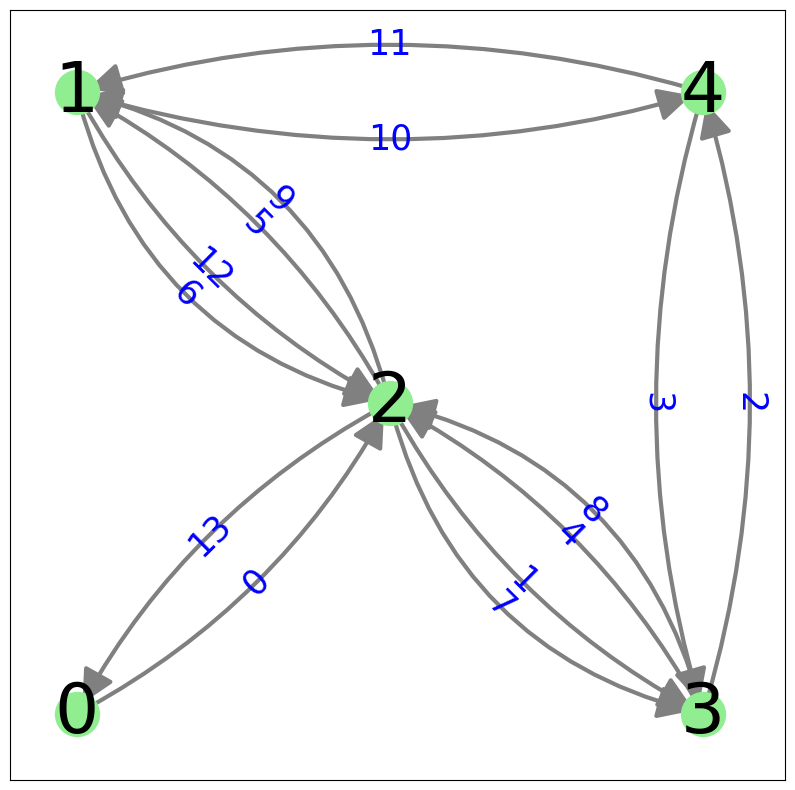

In [85]:
G_Graph = add_order_attribute(G_strong_multi, newRoutes)
draw_labeled_multigraph(G_Graph, node_positions, 'order')


# Interroute Changes: Route Based Crossover

Generating two separate routes and merging them, as in section 3.3 of the paper

In [86]:
def routeGeneration(G, SALT_CAP=10, DEPOT=0, alpha=1, selection_weights=[0.4,0.2,0.4]):
    G_copy = G.copy()
    G_dual = create_dual(G_copy)
    curr_salt = SALT_CAP
    curr_node = DEPOT
    routes = []
    routes_onlyRequired = []

    partial_route: list[RouteStep] = list()
    partial_route_required: list[RouteStep] = list()
    number_of_routes = 0

    while all_serviced(G_copy) == False:
        partial_route, partial_route_required = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route, partial_route_required, DEPOT, curr_salt)
        routes.append(partial_route)
        routes_onlyRequired.append(partial_route_required)

        curr_salt = SALT_CAP
        curr_node = DEPOT

        partial_route = list()
        partial_route_required = list()
        number_of_routes += 1
    return routes, routes_onlyRequired

S1_all, S1 = routeGeneration(G_strong_multi)
S2_all, S2 = routeGeneration(G_strong_multi)

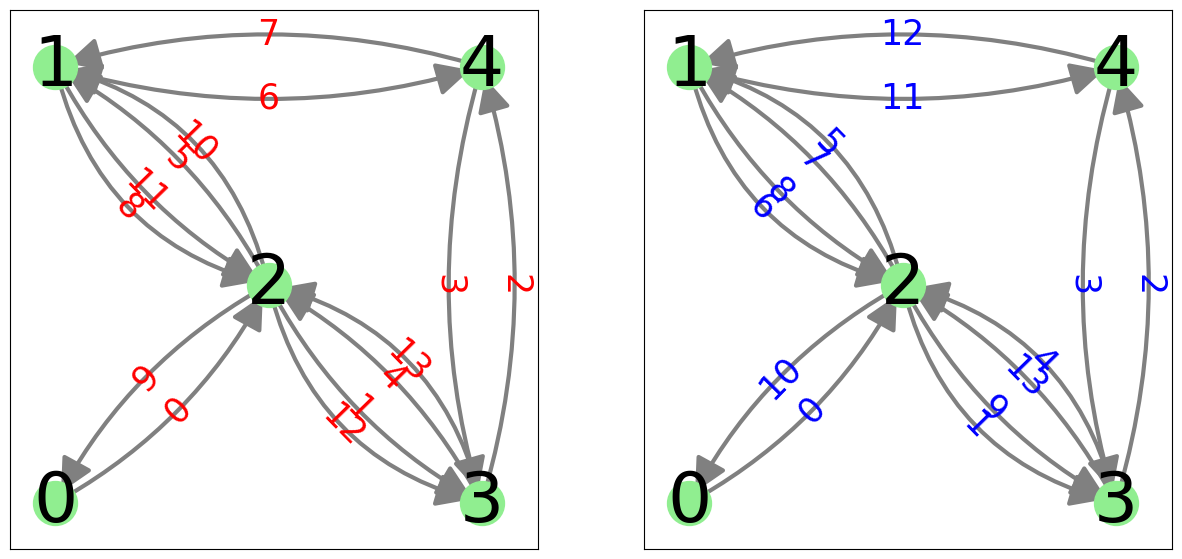

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

G_GraphS1 = add_order_attribute_from_edges(G_strong_multi, S1)
G_GraphS2 = add_order_attribute_from_edges(G_strong_multi, S2)
draw_labeled_multigraph(G_GraphS1, node_positions, 'order', ax1, color='red')
draw_labeled_multigraph(G_GraphS2, node_positions, 'order', ax2, color='blue')

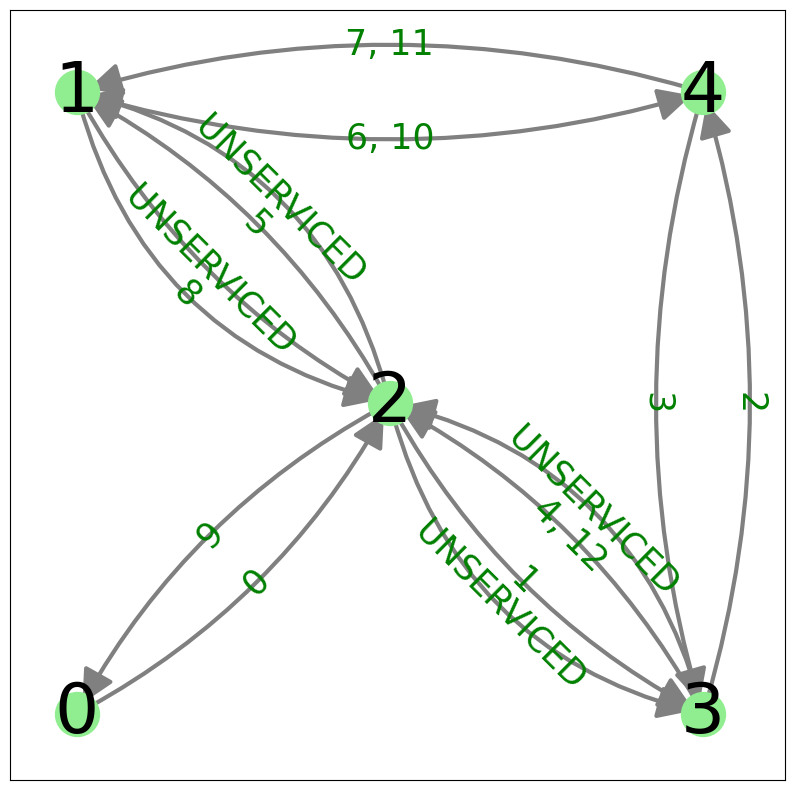

In [88]:
np.random.seed(0)

S0 = copy.deepcopy(S1)
removeRouteIndex = int(np.random.random()*len(S1))
addRouteIndex = int(np.random.random()*len(S2))

# make the swap
S0[removeRouteIndex] = S2[addRouteIndex]

G_GraphS0 = add_order_attribute_from_edges(G_strong_multi, S0)
draw_labeled_multigraph(G_GraphS0, node_positions, 'order', color='green')


## First, remove duplicate tasks

Note that if only non-deadheaded traversals are recorded, then duplicates will be at most of length 2 (no more than two traversals)

Procedure: 

Each duplicated task $T_i$, it is sandwiched between two other tasks:
$$T_{i-1}, T_{i}, T_{i+1}$$
Only keep the task that has the minimum distance between $T_{i-1}$ and $T_{i+1}$

Remove the occurence with the largest of the following value (largest savings with removal):

dist($T_{i-1}$, $T_{i}$) + dist($T_{i}$, $T_{i+1}$) - dist($T_{i-1}$, $T_{i+1}$)



At the start and end of each subroute, we need to add a dummy task for the depot with 0 weight to serve as a buffer for computing distances

In [89]:
def removeDuplicates(changed_route_index, routes):
    newRoutes = copy.deepcopy(routes)

    added_route = newRoutes[changed_route_index]

    for h in range(len(routes)):
        route = routes[h]
        if h == changed_route_index:
            continue
        for i in range(len(route)):
            edge = route[i]
            if edge in added_route:
                # duplicate
                j = added_route.index(edge)
                prevEdge = DEPOT if j == 0 else added_route[j-1]
                nextEdge = DEPOT if j == len(added_route)-1 else added_route[j+1]

                diff1 = get_dist(prevEdge, edge) + get_dist(edge, nextEdge) - get_dist(prevEdge, nextEdge)

                prevEdge = DEPOT if i == 0 else route[i-1]
                nextEdge = DEPOT if i == len(route)-1 else route[i+1]

                diff2 = get_dist(prevEdge, edge) + get_dist(edge, nextEdge) - get_dist(prevEdge, nextEdge)

                if diff2 > diff1:
                    added_route.remove(edge)
                else:
                    newRoutes[h].remove(edge)
    return newRoutes    
S0_new = removeDuplicates(removeRouteIndex, S0)

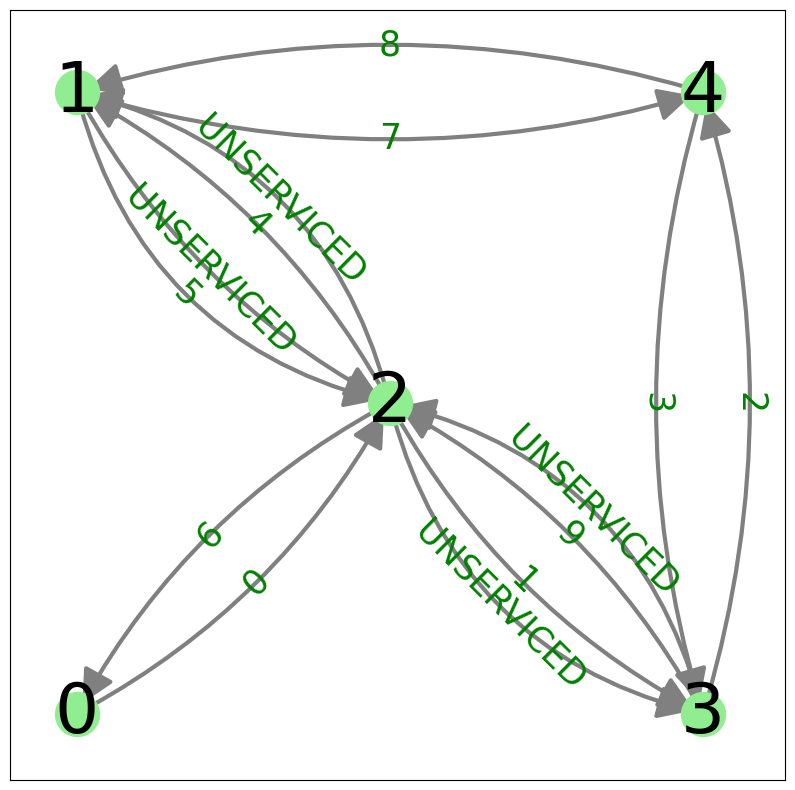

In [90]:
G_GraphS0 = add_order_attribute_from_edges(G_strong_multi, S0_new)
draw_labeled_multigraph(G_GraphS0, node_positions, 'order', color='green')


## Second, add unserviced tasks

Identify all unserviced tasks

In [91]:
condensed_routes = list()
for route in S0:
    for edge in route:
        condensed_routes.append(edge)

unservicedEdges = set(G_strong_multi.edges)-set(condensed_routes)
print(unservicedEdges)

{(2, 3, 1), (2, 1, 1), (3, 2, 1), (1, 2, 0)}


Identifying cost of insertion

In [92]:
def routes_cost(G, routes, NUMROUTES_PENALTY, DEADHEAD_PENALTY):
    '''
    Returns the cost of a set of routes. The routes should only contain serviced edges.
    routes is a list a tuples that represent edges
    '''
    cost = 0
    time = 0
    for route in routes:
        for i in range(len(route)):
            edge = route[i]

            # penalize the turn
            if i+1 < len(route):
                next_edge = route[i+1]
                # add cost, which incorpates turn penalties already
                cost += get_dist(edge, next_edge) 
            else:
                # last required edge in the route, consider return to DEPOT
                cost += get_dist(edge, DEPOT)

            # penalize priorities
            edge_data = G[edge[0]][edge[1]][edge[2]]
            time += edge_data['travel_time']
            priority_cost = edge_data['priority'] * time
            
            cost += priority_cost
        # penalize number of returns to depot
        cost += NUMROUTES_PENALTY

    # penalize deadheading
    for edge in G.edges(data=True):
        cost += edge[2]['deadheading_passes']*DEADHEAD_PENALTY
    return cost

routes_cost(G_strong_multi, S0, 10, 10)

405.0

In [93]:
# Loop through routes with closed loops removed
# At each instance where we are at the closed loop node, evaluate the total cost of the route
# when inserting the closed loop at that point
# Choose the best insertion point

def insertEdge(edge, routes : list[list[tuple]]):
    '''
    Inserts a loop into a full set of routes
    '''
    new_routes = routes.copy()

    bestSpot = None
    bestInsertionCost = math.inf

    for route_id in range(len(new_routes)):
        route = new_routes[route_id]
        for i in range(len(route)+1):
            newRoute = route[:i] + [edge] + route[i:]
            newCompleteRoutes = new_routes[:route_id] + [newRoute] + new_routes[route_id+1:]
            newCost = routes_cost(G_strong_multi, newCompleteRoutes, 10, 10)

            if newCost < bestInsertionCost:
                bestInsertionCost = newCost
                bestRoute = newCompleteRoutes

    return bestRoute

In [94]:
for edge in unservicedEdges:
    S0_new = insertEdge(edge, S0_new)

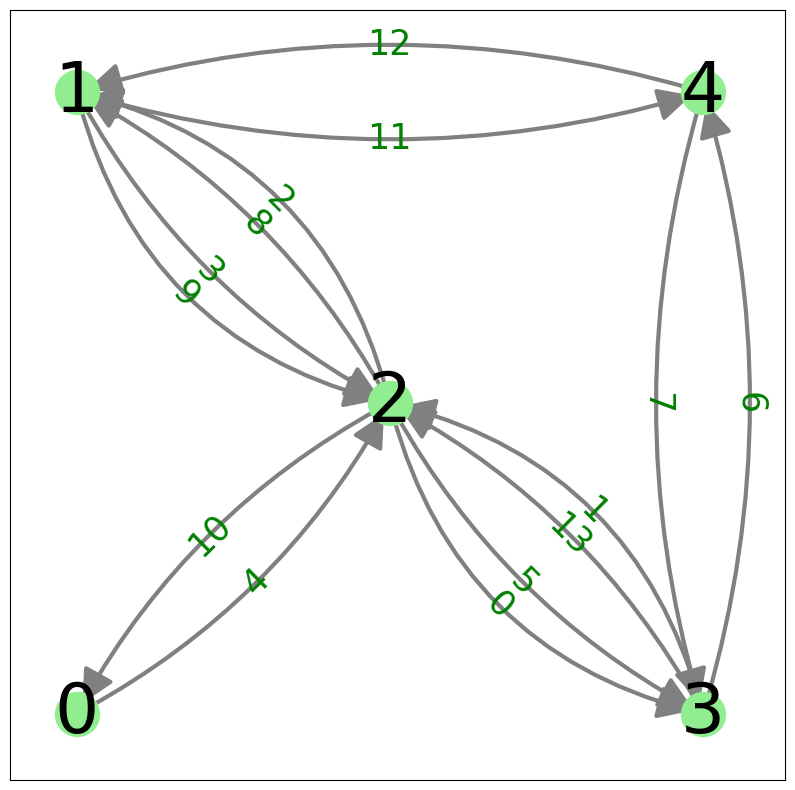

In [95]:
G_GraphS0 = add_order_attribute_from_edges(G_strong_multi, S0_new)
draw_labeled_multigraph(G_GraphS0, node_positions, 'order', color='green')

## Intraroute Changes: Local Tuning

1. Adding and removing closed loops (like before)
2. Relocate (insert)
- Move a after c
3. Relocate-2 (double insert)
- Move a-b after c

3. Swap
Swap a and c
4. 2-opt (see explanation)

Route 1: ABCD
Route 2: EFGH

Two opt between B and F:

Route 1: ABGH
Route 2: EFCD

Two opt between A and C:
Route 1: ACBD
Route 2: EGFH

To determine how to which arcs to swap, consider the $k$ closest neighbroing arcs of the first $n$ most costly arcs


## Route representation
Idea: Use a linked list-based representation so that adding and removing within become O(1) operations.

Each edge is represetned by a node object.

RouteStep node attributes:
- Current edge
- Previous edge
- Next edge
- Route ID

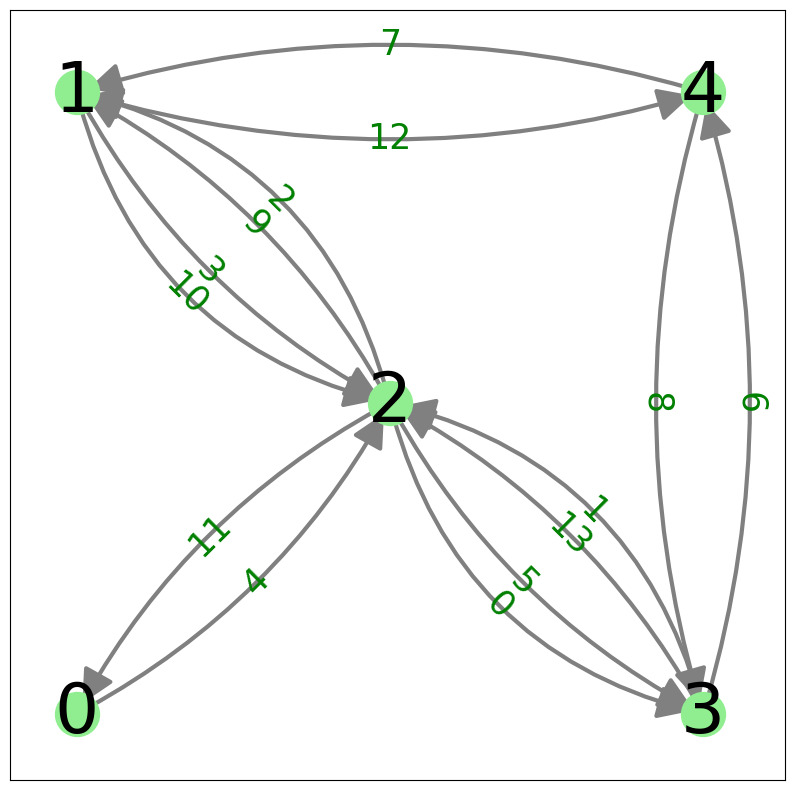

In [107]:
## Interroute Changes: Route Based Crossover

def relocate(S, edge1, edge2, indices1 = None, indices2 = None):

    # locate the indices if they aren't provided
    if indices1 == None:
        for i in range(len(S)):
            route = S[i]
            if edge1 in route:
                indices1 = (i, route.index(edge1))
                break

    if indices2 == None:
        for i in range(len(S)):
            route = S[i]
            if edge2 in route:
                indices2 = (i, route.index(edge2))
                break

    # relocate: move edge 1 after edge 2
    S[indices1[0]].remove(edge1)
    S[indices2[0]] = S[indices2[0]][:indices2[1]+1] + [edge1] + S[indices2[0]][indices2[1]+1:]

S0_testing = copy.deepcopy(S0_new)
relocate(S0_testing, (4,1,0), (3,4,0))
G_GraphS0 = add_order_attribute_from_edges(G_strong_multi, S0_testing)
draw_labeled_multigraph(G_GraphS0, node_positions, 'order', color='green')

In [98]:
## Interroute Changes: Route Based Crossover

def relocate(edge1, edge2):

def relocate2(edge1, edge2):

def swap(edge1, edge2):

def two_opt(edge1, edge2):

IndentationError: expected an indented block after function definition on line 3 (1144744247.py, line 5)